In [263]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [50]:
from __future__ import print_function # so print doesn't show brackets
import numpy as np
import itertools as itr

import os as os
import sys as sys 
import pandas as pd
import warnings
import time as time
import random
import pickle
pickle.HIGHEST_PROTOCOL = 2
sys.path.append(os.path.join("..", "Libraries","QML_lib"))
from RedisSettings import *
import Evo as evo
import DataBase 
from QMD import QMD #  class moved to QMD in Library
import QML
import ModelGeneration 
import BayesF
import matplotlib.pyplot as plt
import PlotQMD as ptq
#from pympler import asizeof
import matplotlib.pyplot as plt
paulis = ['x', 'y', 'z'] # will be chosen at random. or uncomment below and comment within loop to hard-set

import viz_library as v
import time as time 
import argparse

parser = argparse.ArgumentParser(description='Pass variables for (I)QLE.')

import warnings
warnings.filterwarnings("ignore")


In [51]:
qmd=pickle.load(open('Results/12_Apr_18/9_42/qmd_class_001.p', "rb"))

In [ ]:
def available_position_list(max_this_branch, max_any_branch):   
    # Used to get a list of positions to place nodes centrally 
    N = 2*max_any_branch - 1
    all_nums = list(range(N))
    evens = [a for a in all_nums if a%2==0]
    odds = [a for a in all_nums if a%2!=0]    
    
    diff = max_any_branch-max_this_branch 
    if diff%2==0:
        all_positions = evens
        even_odd = 'even'
    else:
        all_positions = odds
        even_odd = 'odd'

    if diff > 1:
        if even_odd=='even':
            to_cut = int(diff/2)
            available_positions = all_positions[to_cut:-to_cut]
        else:
            to_cut = int((diff)/2)
            available_positions = all_positions[to_cut:-to_cut]
    else:
        available_positions = all_positions
        
    return available_positions

In [351]:
list(qmd.BranchChampions.values())

[0.0, 3.0, 5.0, 8.0, 9.0, 11.0, 13.0, 16.0, 17.0]

In [352]:
qmd.ChampionName

'xTiPPyTiPPzTiPPzTzPPxTxPPyTyPPyTz'

In [353]:
qmd.ChampID = 5

In [503]:
def plotTreeDiagram(qmd, modlist=None, save_to_file=None, only_adjacent_branches=True, directed=False):
    plt.clf()
    plt.figure(figsize=(16,11))
    if directed:
        G=nx.DiGraph()
    else:
        G=nx.Graph()
    losing_node_colour = 'r'
    branch_champ_node_colour = 'b'
    overall_champ_node_colour = 'g'
    positions = {}
    labels = {}
    edges_weights = {}
    branch_x_filled = {}
    branch_mod_count = {}
    node_colours = {}
    
    
    max_branch_id = qmd.HighestBranchID
    max_mod_id = qmd.HighestModelID
    if modlist is None:
        modlist = range(max_mod_id)
    for i in range(max_branch_id+1):
        branch_x_filled[i] = 0
        branch_mod_count[i] =  0 

    for i in modlist:
        G.add_node(i)
        node_colours[i] = losing_node_colour
        mod = qmd.reducedModelInstanceFromID(i)
        name = mod.Name
        branch=qmd.pullField(name=name, field='branchID')
        branch_mod_count[branch] += 1
        latex_term = mod.LatexTerm[1:]
        labels[i] = latex_term

    # Set x-coordinate for each node based on how many nodes are on that branch (y-coordinate)
    most_models_per_branch = max(branch_mod_count.values())
    for i in modlist:
        mod = qmd.reducedModelInstanceFromID(i)
        name = mod.Name
        branch=qmd.pullField(name=name, field='branchID')
        num_models_this_branch = branch_mod_count[branch]
        pos_list = available_position_list(num_models_this_branch, most_models_per_branch)
        branch_filled_so_far = branch_x_filled[branch]
        branch_x_filled[branch]+=1
        
        x_pos = pos_list[branch_filled_so_far]
        y_pos = branch
        positions[i] = (x_pos, y_pos)

    # set node colour based on whether that model won a branch 
    for b in list(qmd.BranchChampions.values()):
        node_colours[b] = branch_champ_node_colour
    node_colours[qmd.ChampID] = overall_champ_node_colour
    
    edges = []
    for a in modlist:
        for b in modlist:
            if adjacent_branch_test(qmd, a, b) or only_adjacent_branches==False:
                if a!=b:
                    unique_pair = DataBase.unique_model_pair_identifier(a,b)
                    if unique_pair not in edges and unique_pair in qmd.BayesFactorsComputed:
                        edges.append(unique_pair)
    edge_tuples = []
    weights = []
    for pair in edges:
        mod_ids = pair.split(",")
        pair_tuple=tuple([int(s) for s in mod_ids])
        pair_bf = qmd.AllBayesFactors[float(mod_ids[0])][float(mod_ids[1])][-1]
        weights.append(pair_bf)
        edge_tuples.append(pair_tuple)

    weights = np.log10(weights)
    
    print("Len weights:", len(weights))
    print("Len edge tuples:", len(edge_tuples))
    
    flipped=unflipped=0
    # flip edges so they point TO winner for directed graph
    for i in range(len(weights)):
        if weights[i] < 0:
            edge_tuples[i] = edge_tuples[i][::-1]

    weights = tuple(weights)
    edge_tuples = tuple(edge_tuples)
    n_colours = tuple(node_colours.values())
    
    nx.draw_networkx(
        G, 
        labels=labels, 
        pos=positions, 
        k=1.5, #node spacing
        arrows=True,
        width=5,
        arrowstyle='->',
        head_length=0.9,
        head_width=1.8,
        node_size=5000,
        linewidth=5,
        node_shape='8',
        node_color=n_colours,
        edgelist=edge_tuples,
        edge_color=weights, 
        edge_cmap=plt.cm.Spectral,
    )  
    
    edges_for_cmap = nx.draw_networkx_edges(G, pos=positions, arrows=True, edgelist=edge_tuples, edge_color=weights, edge_cmap=plt.cm.Spectral)
    #nx.draw_networkx_edges(G, pos=positions, arrows=True, arrowstyle='->', edgelist=edge_tuples, edge_color=weights)
    
    plt.tight_layout()
    plt.gca().invert_yaxis() # so branch 0 on top
    plt.gca().get_xaxis().set_visible(False)
    plt.ylabel('Branch')
    if not directed:
        plt.colorbar(edges_for_cmap) #TODO for some reason this doesn't work for DiGraph so no colorbar shows?
    else:
        pass
        
    plt.title('Tree Diagram for QMD')

    if save_to_file is not None:
        plt.savefig(save_to_file, bbox_inches='tight')
    plt.show()

Len weights: 20
Len edge tuples: 20


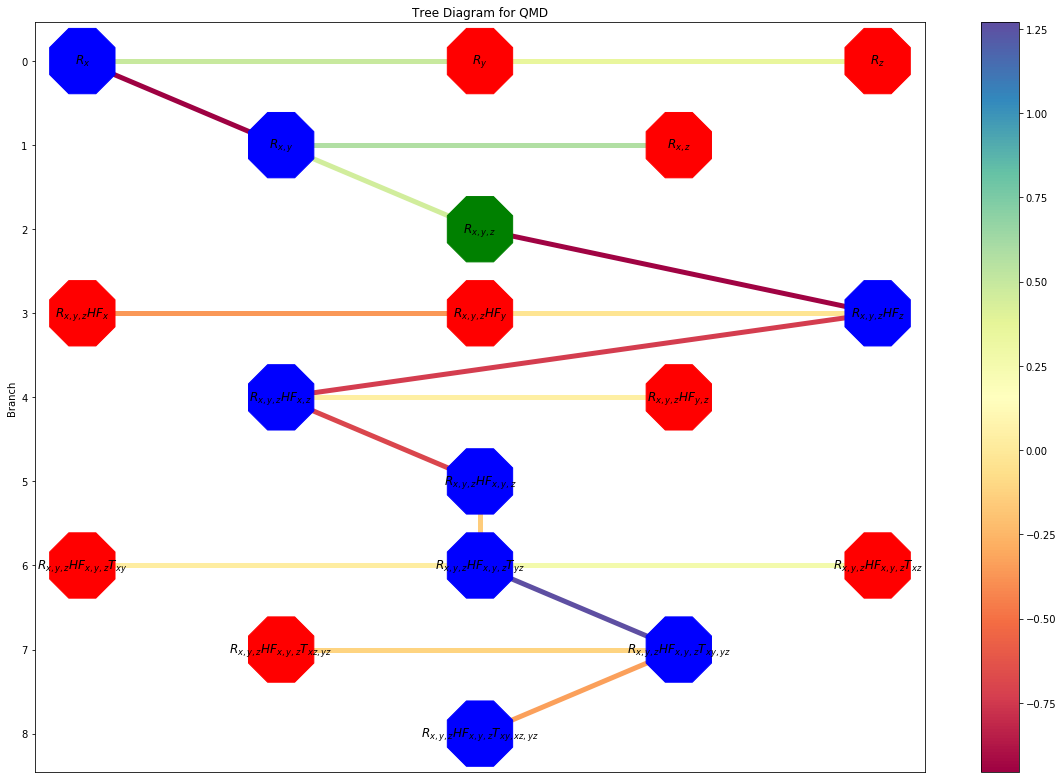

In [507]:
plotTreeDiagram(qmd, only_adjacent_branches=True, directed=0)

In [510]:
list(qmd.BranchChampions.values())

[0.0, 3.0, 5.0, 8.0, 9.0, 11.0, 13.0, 16.0, 17.0]

Len weights: 8
Len edge tuples: 8


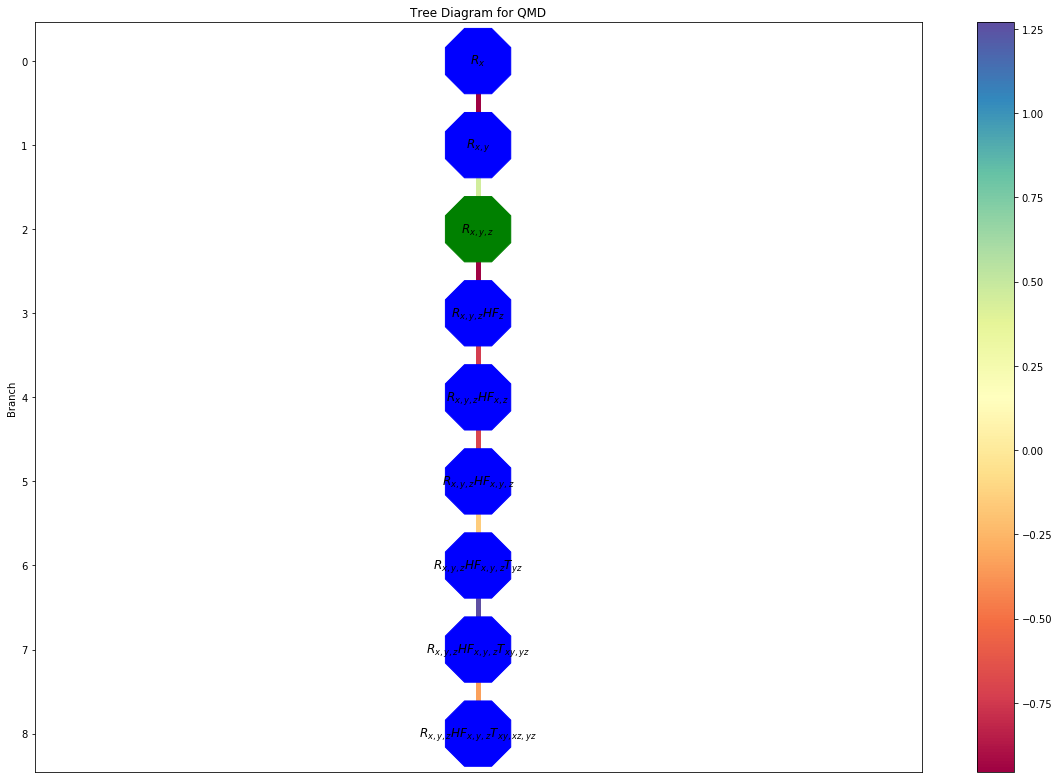

In [511]:
plotTreeDiagram(qmd, modlist=list(qmd.BranchChampions.values()) ,only_adjacent_branches=True, directed=0)

In [361]:
def adjacent_branch_test(qmd, mod1, mod2):
    mod_a = qmd.reducedModelInstanceFromID(mod1).Name
    mod_b = qmd.reducedModelInstanceFromID(mod2).Name
    br_a = qmd.pullField(name=mod_a, field='branchID')
    br_b = qmd.pullField(name=mod_b, field='branchID')
       
    diff = br_a - br_b
    if diff in [-1, 0, 1]:
        return True
    else:
        return False